### from https://www.kaggle.com/startupsci/titanic-data-science-solutions

In [140]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

---
# Explore
---

In [141]:
grouped=train_df[['Pclass','Survived']].groupby(['Pclass'],as_index=False)
grouped.mean().sort_values(by='Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [142]:
grouped=train_df[['Sex','Survived']].groupby(['Sex'],as_index=False)
grouped.mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [143]:
grouped=train_df[['SibSp','Survived']].groupby(['SibSp'],as_index=False)
grouped.mean().sort_values(by='Survived',ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [144]:
grouped=train_df[['Parch','Survived']].groupby(['Parch'],as_index=False)
grouped.mean().sort_values(by='Survived',ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


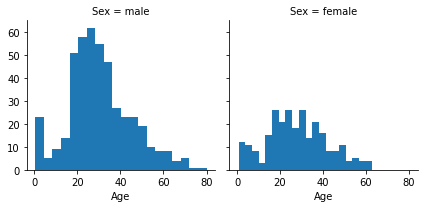

In [145]:
g = sns.FacetGrid(train_df, col='Sex')
g.map(plt.hist, 'Age', bins=20)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


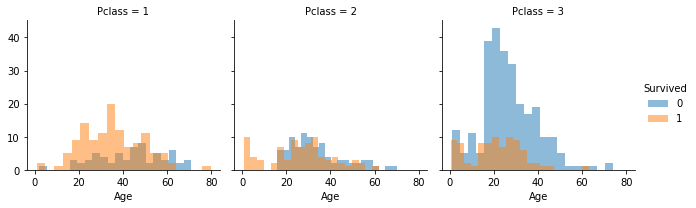

In [146]:
grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


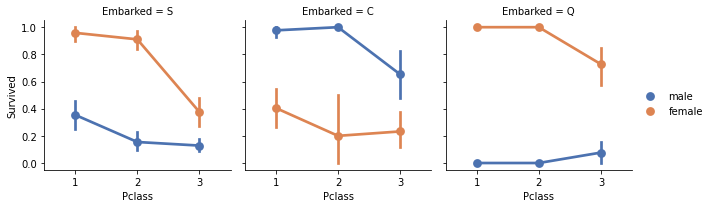

In [147]:
grid = sns.FacetGrid(train_df, col='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


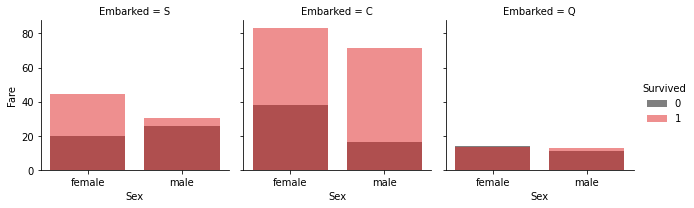

In [148]:
grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'black', 1: 'r'})
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

basically, the above plot implies that for people starting from S and C,
survived people generally paid much more than those who did not to get on the boat.

---
# Preprocessing
---

In [149]:
combine=[train_df,test_df]
for dataset in combine:
    dataset['Title']=dataset['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
#pd.crosstab(train_df['Title'],train_df['Sex'])
for dataset in combine:
    dataset['Title']=dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title','Survived']].groupby('Title',as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [150]:
for dataset in combine:
    dataset['Title']=dataset['Title'].factorize()[0]+1
    dataset['Age'].fillna(dataset['Age'].median(),inplace=True)
    bins = [0, 18, 35, 65, np.inf]
    labels=list(map(str,range(1,len(bins))))
    dataset['Age']=pd.cut(dataset['Age'],bins=bins,labels=labels)
    dataset['Age']=dataset['Age'].factorize()[0]+1
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median(),inplace=True)
    dataset['Sex']=dataset['Sex'].factorize()[0]+1
    dataset['Embarked']=dataset['Embarked'].factorize()[0]+1
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

    
drop_col=['Ticket','Cabin','Name','SibSp','Parch']
train_df=train_df.drop(drop_col,axis=1)
test_df=test_df.drop(drop_col,axis=1)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,892,3,1,1,7.8292,1,1,1
1,893,3,2,2,7.0000,2,2,2
2,894,2,1,2,9.6875,1,1,1
3,895,3,1,1,8.6625,2,1,1
4,896,3,2,1,12.2875,2,2,3


In [151]:
import numpy as np
import xgboost

x_train=train_df.loc[:,train_df.columns!='Survived']
y_train=np.array(train_df.loc[:,'Survived']).reshape(-1,1)
xgb_classifier=xgboost.XGBClassifier()
xgb_classifier.fit(x_train,y_train)
xgb_classifier.score(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9910213243546577

In [152]:
predictions=xgb_classifier.predict(test_df)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':predictions})
submission.to_csv('feature_eng_xgboost.csv',index=False)
!kaggle competitions submit -c titanic -f './feature_eng_xgboost.csv' -m 'feature eng xgboost'

100%|██████████████████████████████████████| 2.77k/2.77k [00:01<00:00, 2.20kB/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (13 hours from now).


In [153]:
!kaggle competitions submissions -c titanic

fileName                 date                 description          status    publicScore  privateScore  
-----------------------  -------------------  -------------------  --------  -----------  ------------  
feature_eng_xgboost.csv  2020-09-25 09:59:58  feature eng xgboost  complete  0.78708      None          
feature_eng_xgboost.csv  2020-09-25 09:42:18  feature eng xgboost  complete  0.77272      None          
feature_eng_xgboost.csv  2020-09-25 09:40:57  feature eng xgboost  complete  0.77272      None          
feature_eng_xgboost.csv  2020-09-25 09:17:38  feature eng xgboost  complete  0.74880      None          
vanilla_xgboost.csv      2020-09-25 04:57:17  vanilla xgboost      complete  0.76076      None          
vanilla_xgboost.csv      2020-09-25 04:56:55  vanilla xgboost      complete  0.75837      None          
vanilla_xgboost.csv      2020-09-25 04:54:54  vanilla xgboost      complete  0.77033      None          
vanilla_xgboost.csv      2020-09-25 04:50:08  vanilla x